<h1 style="color:#2bf0b5;"> <b>Neuroscience</b> HW3-1 - Lachin Naghashyar</h1>

---

<h2 style="color:#f06ff2;"> <b> Implementation of two layer neural network on HAND DIGIT problem (recgonize the handwritten digits)</b></h2>

**Q1:** Load the data set of numbers (data.mat) and illustrate 100 of them randomly:
we can also see that the inputs will be 20 x 20 grey scale images “unrolled” to form 400 input features which we will feed into the neural network. This way, the input layer will have 400 neurons also we use 25 neurons in the hidden layers and 10(for each digit) neurons in the output layer. (+ one bias node in each of the first two layers)

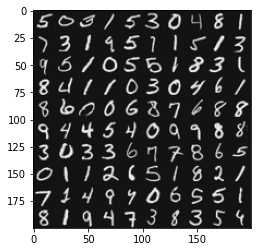

In [305]:
from matplotlib import pyplot as plt
import numpy as np
import scipy.io

data = scipy.io.loadmat('data.mat')
X = np.array(data["X"]) # 5000 * 400
y = np.array(data["y"]) # 5000 * 1

input_layer_size = 400
hidden_layer_size = 25
num_labels = 10

rand_100 = X[np.random.choice(X.shape[0], 100, replace=False)] # array which contains 100 rows of X chosen randomly
pics = np.zeros((200, 200)) # convert each row in to a 20 * 20 image and add it to pics
for i in range(10):
    for j in range(10):
        pics[i*20:i*20+20,j*20:j*20+20] = np.reshape(rand_100[i+10*j,:], (20, 20), order='F')

plt.imshow(pics, cmap=plt.get_cmap('gray'))
plt.show()


**Q2:** Split train and test sets

In [306]:
# we have 500 rows for each number. we use the first 300 in the training set.
train_set = np.zeros((300*10, 400))
test_set = np.zeros((200*10, 400))
y_train = np.zeros((300*10, 1), dtype='uint8')
y_test = np.zeros((200*10, 1), dtype='uint8')
for i in range(10):
    train_set[i*300:i*300+300,:] = X[i*500:i*500+300,:]
    test_set[i*200:i*200+200,:] = X[i*500:i*500+200,:]
    y_train[i*300:i*300+300,:] = y[i*500:i*500+300,:]
    y_test[i*200:i*200+200,:] = y[i*500:i*500+200,:]

**Q3:** build the neural network with 2 layers. The input layer has 400 neurons, the hidden layer has 25 and the output layer has 10.

choose the weight matrix as a random one and not all zeros. Choosing the weights to be all zeros makes the parameters corresponding to inputs going in to each layer to be identical (even after gradient descent update, the values will again become identical). This way all the hidden units are computing the exact same values which is redundant (network failing to break symmetry). And not only zero, any constant initialization will produce a poor result. Therefore, random initialization breaks the symmetry and gives much better accuracy.

 $ W = rand(L_{out}, 1+L_{in}) * 2 * \epsilon - \epsilon, \epsilon = 0.12$

Also note that for a weight matrix mapping from layer $i$ to $i+1$ which have respectively $L_{in} = s_i$ and $L_{out} = s_{i+1}$ neurons, has a dimension of $s_{i+1} \times s_{i}$. The extra one neuron which is added, is the bias unit that allows us to shift the activation function by a constant (the given bias) to the input. It is used to adjust the output along with the weighted sum of the inputs to the neuron. Therefore, bias unit is a constant which helps the model in a more flexible way that it can fit best for the given data.

In [307]:
def random_weight_initialization(L_in, L_out, epsilon):
    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon - epsilon
    return W

In [308]:
theta1 = random_weight_initialization(400, 25, 0.12)
theta2 = random_weight_initialization(25, 10, 0.12)

**Q4:** compute the gradient of cost function

\begin{aligned}
J(\theta)=& \frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K}\left[-y_{k}^{(i)} \log \left(\left(h_{\theta}\left(x^{(i)}\right)\right)_{k}\right)-\left(1-y_{k}^{(i)}\right) \log \left(1-\left(h_{\theta}\left(x^{(i)}\right)\right)_{k}\right)\right]+\\
& \frac{\lambda}{2 m}\left[\sum_{j=1}^{25} \sum_{k=1}^{400}\left(\Theta_{j, k}^{(1)}\right)^{2}+\sum_{j=1}^{10} \sum_{k=1}^{25}\left(\Theta_{j, k}^{(2)}\right)^{2}\right] .
\end{aligned}


with m being the number of the examples and  k being 10 which is the number of labels. In y vectors, we use 1 and 0s. The index of the only 1 value in it, shows the corresponding number of that example.

In gradient computation for backpropagation, we set $\delta_{i}^{(l)}=$ to be the **error** of node $i$ in layer $l$. They are computed this way:

\begin{center}
$\delta_{i}^{(3)}=a_{i}^{(3)}-y_{i}$
\\
$\delta^{(2)}=(\Theta^{(2)})^{T} \delta^{(3)} \cdot^* g^{\prime}(z^{(2)})$
\end{center}

and for a more general way, we will have:
- set $D_{i, j}^{(l)} = 0$ for all $i, j$ and $l$. These terms are used in computing the partial derivatives
- run a for loop from 1 to m and in each iteration:
    - compute $\delta^{(L)}=a^{(L)}-y^{(t)}$ and for the other layers, compute Compute $\delta^{(L-1)}, \delta^{(L-2)}, \ldots, \delta^{(2)}$ using $\delta^{(l)}=\left(\left(\Theta^{(l)}\right)^{T} \delta^{(l+1)}\right) \cdot^* g^{\prime}\left(z^{(l)}\right)$
    where $g^{\prime}$ is the derivative of the activation function $g(z)$. And we have $
    g^{\prime}\left(z^{(l)}\right)=a^{(l)} \cdot *\left(1-a^{(l)}\right)$
    - set $\Delta_{i, j}^{(l)}:=\Delta_{i, j}^{(l)}+a_{j}^{(l)} \delta_{i}^{(l+1)}$ or with vectorization, $\Delta^{(l)}:=\Delta^{(l)}+\delta^{(l+1)}\left(a^{(l)}\right)^{T}$

    We can update the $\Delta$ matrix.
    - $D_{i, j}^{(l)}:=\frac{1}{m}\left(\Delta_{i, j}^{(l)}+\lambda \Theta_{i, j}^{(l)}\right)$, for $\mathrm{j} > 0 .$
    - $D_{i, j}^{(l)}:=\frac{1}{m} \Delta_{i, j}^{(l)}$ If $\mathrm{j}=0$
    D is used to add up the values in each iteration and eventually compute the partial derivative. This way, we get $\frac{\partial}{\partial \Theta_{i j}^{(l)}} J(\Theta)=D_{i j}^{(l)}$



Also, for the derivative of sigmoid function we have:

\begin{aligned}
\frac{d}{d x} \sigma(x) &=\frac{d}{d x}\left[\frac{1}{1+e^{-x}}\right] \\
&=\frac{d}{d x}\left(1+\mathrm{e}^{-x}\right)^{-1} \\
&=-\left(1+e^{-x}\right)^{-2}\left(-e^{-x}\right) \\
&=\frac{e^{-x}}{\left(1+e^{-x}\right)^{2}} \\
&=\frac{1}{1+e^{-x}} \cdot \frac{e^{-x}}{1+e^{-x}} \\
&=\frac{1}{1+e^{-x}} \cdot \frac{\left(1+e^{-x}\right)-1}{1+e^{-x}} \\
&=\frac{1}{1+e^{-x}} \cdot\left(1-\frac{1}{1+e^{-x}}\right) \\
&=\sigma(x) \cdot(1-\sigma(x))
\end{aligned}

In [309]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def sigmoid_gradient(z):
    return np.multiply(sigmoid(z), (1-sigmoid(z)))

**Q5:** compute cost and gradient using forward and backpropagation

In [310]:
def compute_cost(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambdaa):
    m = X.shape[0]

    # derive theta1 and theta2 from the nn_params which contains all the wights
    theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)], (hidden_layer_size, (input_layer_size + 1)), order='F') # hidden_layer_size *  (input_layer_size + 1)
    theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):], (num_labels, (hidden_layer_size + 1)), order='F') # num_labels * (hidden_layer_size + 1)

    # performing forward propagation
    # first add the bias unit of a vector of ones to a1
    bias_unit = np.ones((m,1))
    a1 = np.concatenate((bias_unit, X),axis=1) # m * 401
    z2 = a1 @ np.transpose(theta1) # m * hidden_layer_size
    a2 = sigmoid(z2)
    a2 = np.concatenate((bias_unit, a2),axis=1) # m * (hidden_layer_size+1)
    z3 = a2 @ np.transpose(theta2) # m * num_labels
    a3 = sigmoid(z3) # a3 =  h_theta(x) m * num_labels

    # also lets create the m * num_labels matrix of the actual values stored in y
    Y = np.zeros((m, num_labels))
    for i in range(m):
        s = y[i]
        Y[i, s-1] = 1

    # compute cost
    J = (1/m) * np.sum(np.sum(-np.multiply(Y, np.log(a3)) - np.multiply((1-Y), np.log(1-a3)))) + (lambdaa/ (2 * m)) * (np.sum(np.sum(np.power(theta1[:,1:], 2), axis=1)) + np.sum(np.sum(np.power(theta2[:,1:], 2), axis=1)))
    return J


def compute_gradient(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambdaa):
    m = X.shape[0]
    bias_unit = np.ones((m,1))

    # derive theta1 and theta2 from the nn_params which contains all the wights
    theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)], (hidden_layer_size, (input_layer_size + 1)), order='F') # hidden_layer_size *  (input_layer_size + 1)
    theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):], (num_labels, (hidden_layer_size + 1)), order='F') # num_labels * (hidden_layer_size + 1)

    # backpropagation
    theta1_grad = np.zeros_like(theta1)
    theta2_grad = np.zeros_like(theta2)
    A1 = np.concatenate((bias_unit, X),axis=1) # m * 401
    Z2 = A1 @ np.transpose(theta1) # m * hidden_layer_size
    A2 = np.concatenate((bias_unit, sigmoid(Z2)),axis=1) # m * (hidden_layer_size + 1)
    Z3 = A2 @ np.transpose(theta2) # m * num_labels
    A3 = sigmoid(Z3)

    Y = np.zeros((m, num_labels))
    for i in range(m):
        s = y[i]
        Y[i, s-1] = 1

    delta3 = A3 - Y # m * num_labels
    delta2 = np.multiply((delta3 @ theta2), np.c_[bias_unit, sigmoid_gradient(Z2)])
    delta2 = delta2[:, 1:]
    theta1_grad = np.transpose(delta2) @ A1
    theta2_grad = np.transpose(delta3) @ A2
    theta1_grad, theta2_grad = theta1_grad/m, theta2_grad/m
    # add the regularization term
    theta1_grad[:, 1:] += (lambdaa/m) * theta1[:,1:]
    theta2_grad[:, 1:] += (lambdaa/m) * theta2[:,1:]
    gradient = np.hstack((theta1_grad.ravel(order='F'), theta2_grad.ravel(order='F')))
    return gradient

    ## non-vectorized implementation
    # one = np.ones((1,1))
    # for i in range(m):
    #     a1 = np.transpose(X[i,:]).reshape((X.shape[1], 1)) # 401 * 1
    #     z2 = theta1 @ a1 # hidden_layer_size * 1
    #     a2 = np.r_[one, z2]# (hidden_layer_size + 1) * 1
    #     z3 = theta2 @ a2 # num_labels * 1
    #     a3 = sigmoid(z3)
    #     # we need y[i] to be a num_labels * 1 vector where only the actual number is one
    #     yi = np.zeros((num_labels,1))
    #     yi[y[i]-1] = 1
    #     # calculate deltas
    #     # L = 3, so we should only compute d3 and d2
    #     delta3 = a3 - yi
    #     delta2 = np.multiply((np.transpose(theta2) @ delta3), np.r_[one, sigmoid_gradient(z2)])
    #     delta2 = delta2[1:]
    #     theta1_grad += delta2 @ np.transpose(a1)
    #     theta2_grad += delta3 @ np.transpose(a2)
    #
    # theta1_grad, theta2_grad = theta1_grad/m, theta2_grad/m
    # # add the regularization term
    # theta1_grad[:, 1:] += (lambdaa/m) * theta1[:,1:]
    # theta2_grad[:, 1:] += (lambdaa/m) * theta2[:,1:]
    # gather all the elements of gradients in one vector


**Q6** use fmincg to learn the parameters

In [312]:
from scipy.optimize import fmin_cg
nn_params = np.hstack((theta1.ravel(order='F'), theta2.ravel(order='F')))
# use lambda = 1
theta = fmin_cg(f = compute_cost, fprime=compute_gradient, x0=nn_params, args=(input_layer_size, hidden_layer_size, num_labels, test_set, y_test, 1), maxiter=80)

theta1_res = np.reshape(theta[:hidden_layer_size*(input_layer_size+1)], (hidden_layer_size, input_layer_size+1), order = 'F')
theta2_res = np.reshape(theta[hidden_layer_size*(input_layer_size+1):], (num_labels, hidden_layer_size+1), order='F')

         Current function value: 0.494476
         Iterations: 80
         Function evaluations: 167
         Gradient evaluations: 167


**Q7** prediction step (used argmax to determine the result value in each yi)

In [313]:
def predict(theta1, theta2, X_test, y_test):
    m = X_test.shape[0]
    bias_unit = np.ones((m,1))
    a1 = np.concatenate((bias_unit, X_test),axis=1)# m * 401
    z2 = a1 @ np.transpose(theta1) # m * hidden_layer_size
    a2 = sigmoid(z2)
    a2 = np.concatenate((bias_unit, a2),axis=1) # m * (hidden_layer_size+1)
    z3 = a2 @ np.transpose(theta2) # m * num_labels
    a3 = sigmoid(z3)
    prediction = np.argmax(a3, axis=1).reshape(y_test.shape) + 1
    accuracy = np.mean(prediction == y_test) * 100
    return prediction, accuracy

In [314]:
prediction, accuracy = predict(theta1_res, theta2_res, test_set, y_test)
print(accuracy)

99.05000000000001


As you can see, it has a high accuracy (around 99 percent). We can also plot 100 random images with their predicted values to check this.

In [315]:
def show_100_random_images(X, y):
    rand_idx = np.random.choice(X.shape[0], 100, replace=False)
    x_rand = X[rand_idx]
    y_rand = y[rand_idx]
    fig, axs = plt.subplots(10, 10, figsize = (20, 20))
    for i in range(10):
        for j in range(10):
            img = np.reshape(x_rand[i+10*j,:], (20, 20), order='F')
            axs[i, j].imshow(img)
            axs[i, j].set_title(str(y_rand[i+10*j]))
            axs[i, j].axis('off')

    fig.show()

/var/folders/6r/dxbmyw_55dn0zmh4j162pjth0000gp/T/ipykernel_1099/4179893586.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


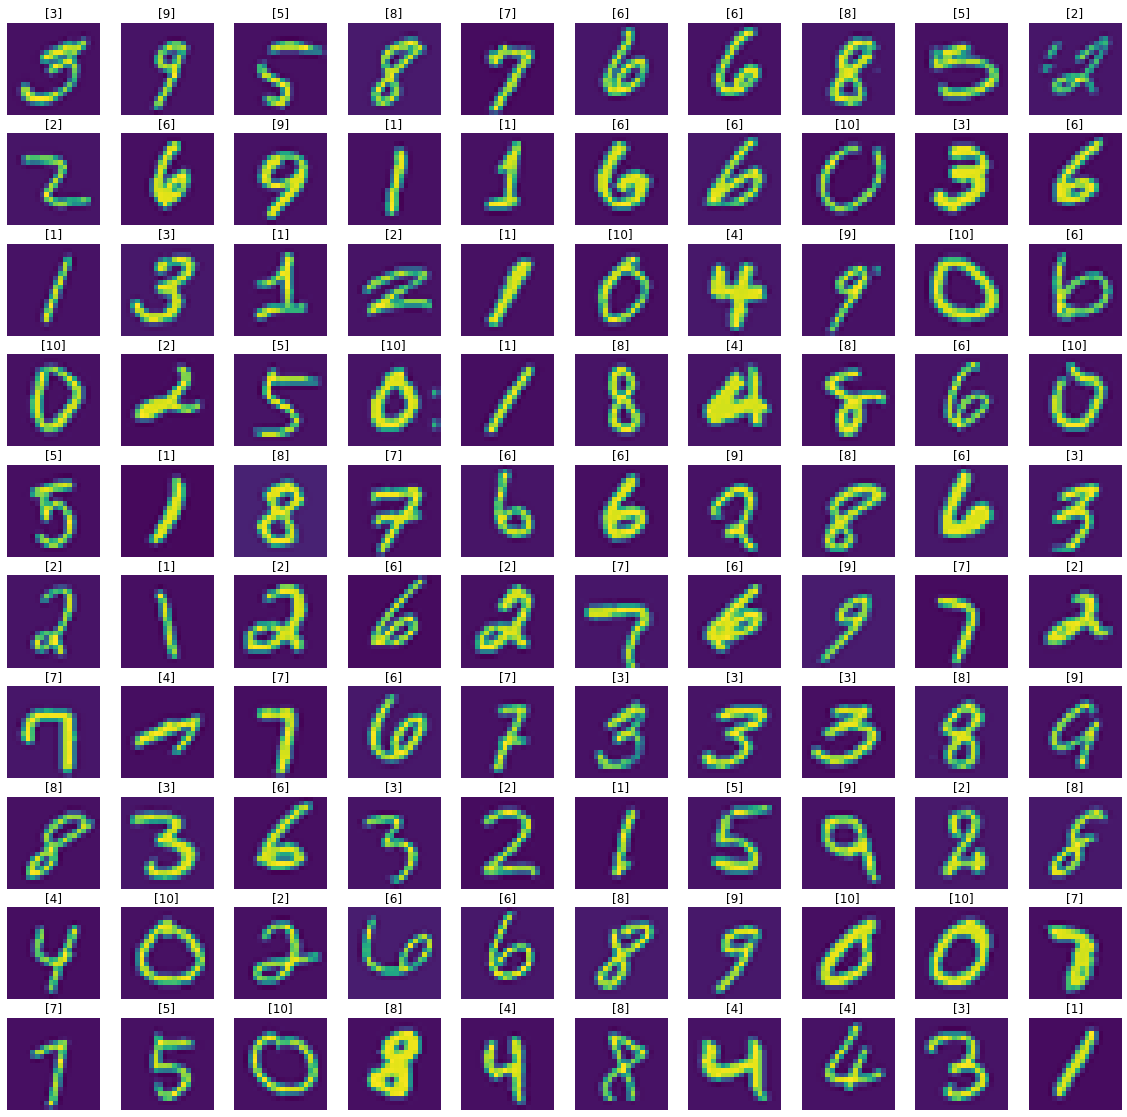

In [316]:
show_100_random_images(test_set, prediction)

**Q8** visualizing the hidden layer: in order to do this, I used the theta1 computed previously. The reason for this is that theta1 contains the weights between the input and hidden layers and since it is a hidden_layer_size $\times$ (input_layer_size + 1) matrix, each row contains 401 elements, we can exclude the bias units and use the 400 vector to reshape it to a $20 \times 20$ image and display it.

In [317]:
def display_hidden_units(theta, image_size, figure_size):
    res = np.zeros((image_size*figure_size, image_size*figure_size))
    for i in range(figure_size):
        for j in range(figure_size):
            res[i*image_size:(i+1)*image_size, j*image_size:(j+1)*image_size] =np.reshape(theta[i*figure_size+j, 1:], (image_size, image_size), order='F')

    plt.imshow(res, cmap=plt.get_cmap('gray'))
    plt.show()

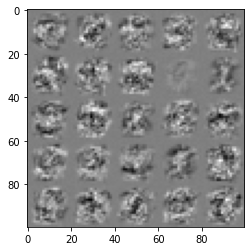

In [318]:
display_hidden_units(theta1_res, 20, 5)